# 02: Training

This notebook loads the data from the previous notebook and trains a model to predict forest attributes. The model is evaluated and saved to disk for later use.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wandb
from sklearn.metrics import r2_score

from naip_cnn import models
from naip_cnn.data import NAIPDatasetWrapper
from naip_cnn.inference import predict_image
from naip_cnn.utils import build_wandb_config

tf.config.list_physical_devices("GPU")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define the parameters used to load the data and train the model.

In [2]:
BANDS = ("R", "G", "B", "N")
# VEG_INDICES = ("EVI", )
# BANDS = tuple()
VEG_INDICES = tuple()
ALL_BANDS = BANDS + VEG_INDICES

LABEL = "cover"
BATCH_SIZE = 8
# DATASET_NAME = "MAL2016_CanyonCreek-1-30-150x150-150"
# DATASET_NAME = "MAL2017_Crow-1-30-150x150-150"
# DATASET_NAME = "MAL2018_Rattlesnake-1-30-150x150-150"
# DATASET_NAME = "HJA2020_5m-5-5-640x640-640"
DATASET_NAME = "MAL2016_CanyonCreek-0p6-30-30x30-30"

EPOCHS = 250
PATIENCE = 25
LEARN_RATE = 0.0001

## Load Data

Before training, we need load our dataset, split it into training and validation sets, and divide it into batches. The same `TrainingDataset` class we used to generate the dataset can be re-used now for training. All of the parameters we defined when generating our training dataset are stored in the file name, allowing us to load a complete `TrainingDataset` from the file we exported earlier.

Additional parameters like the NAIP bands to include, the LiDAR attribute to predict, and the model batch size are defined separately.

In [3]:
wrapper = NAIPDatasetWrapper.from_filename(DATASET_NAME)

train = (
    wrapper.load_train(label=LABEL, bands=BANDS, veg_indices=VEG_INDICES)
    .cache()
    .shuffle(buffer_size=1_000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val = (
    wrapper.load_val(label=LABEL, bands=BANDS, veg_indices=VEG_INDICES)
    .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

## Build the Model

With the data loaded, we can build a CNN model and train it. The `ModelRun` class wraps a Keras model and a `TrainingDataset` and is used to organize, identify, and export a given model run.

In [4]:
model = models.CNN_v2(
    shape=(*wrapper.naip_shape, len(ALL_BANDS)), out_shape=wrapper.lidar_shape
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss="mse",
    metrics=["mae", "mse"],
)

run = models.ModelRun(
    model=model,
    dataset=wrapper,
    label=LABEL,
    bands=ALL_BANDS,
)

## Set Up Experiment Tracking

We'll use [Weights and Biases](https://docs.wandb.ai/) to track our experiments.

In [5]:
# Set the notebook name so W&B can track code
os.environ["WANDB_NOTEBOOK_NAME"] = "02_train_model.ipynb"

# Identify the experiment group based on the output resolution and label
group = f"{wrapper.lidar_res:n}m_{LABEL}"

# Use the dataset, model, and training parameters defined above to build a configuration
# dictionary that will be logged to W&B
config = build_wandb_config(
    dataset=wrapper,
    model_run=run,
    bands=ALL_BANDS,
    label=LABEL,
    batch_size=BATCH_SIZE,
    learn_rate=LEARN_RATE,
    epochs=EPOCHS,
)

# Initialize a new experiment
wandb.init(project="naip-cnn", group=group, config=config, save_code=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: aazuspan (aazuspan-team). Use `wandb login --relogin` to force relogin


## Train the Model

While training the model, we'll use two callbacks: 

- `EarlyStopping` interrupts training if loss stops improving after the number of epochs defined by `patience`. This can reduce training time by aborting once a model starts to overfit, when further epochs are unlikely to improve model performance. Lower `patience` values stop the model sooner, but may trigger prematurely due to random fluctuations in loss.
- `ModelCheckpoint` stores the weights of the best performing epoch, allowing us to restore the optimal model if later epochs begin to overfit. 

*Note that while `EarlyStopping` *can* restore weights, this only works if the callback is triggered, which may not happen if `patience` is not exceeded.*

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", verbose=1, patience=PATIENCE, restore_best_weights=False
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # keras does a second formatting run for the epoch
        filepath=f"../models/.checkpoint_{run.name}_{{epoch:04d}}.h5",
        save_best_only=True,
        save_weights_only=True,
        verbose=False,
        monitor="val_loss",
    ),
    early_stopping,
    wandb.keras.WandbMetricsLogger(),
]

run.model.fit(
    train,
    verbose=1,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/250
59418/59418 [==============================] - 734s 12ms/step - loss: 149.5269 - mae: 9.4715 - mse: 149.5269 - val_loss: 123.3913 - val_mae: 8.6301 - val_mse: 123.3913
Epoch 2/250
59418/59418 [==============================] - 319s 5ms/step - loss: 122.5139 - mae: 8.5849 - mse: 122.5139 - val_loss: 125.4088 - val_mae: 8.6413 - val_mse: 125.4088
Epoch 3/250
59418/59418 [==============================] - 319s 5ms/step - loss: 116.0718 - mae: 8.3282 - mse: 116.0718 - val_loss: 111.0079 - val_mae: 8.1454 - val_mse: 111.0079
Epoch 4/250
59418/59418 [==============================] - 316s 5ms/step - loss: 112.2079 - mae: 8.1675 - mse: 112.2079 - val_loss: 108.2719 - val_mae: 7.9963 - val_mse: 108.2719
Epoch 5/250
59418/59418 [==============================] - 317s 5ms/step - loss: 109.3757 - mae: 8.0528 - mse: 109.3757 - val_loss: 107.0583 - val_mae: 7.9297 - val_mse: 107.0583
Epoch 6/250
59418/59418 [==============================] - 320s 5ms/step - loss: 107.3911 - mae: 7.9680 

Save the model locally and to Weights and Biases.

In [7]:
best_epoch = run.load_best_checkpoint()
stopped_epoch = early_stopping.stopped_epoch if early_stopping else EPOCHS

run.save_model()
wandb.log_model(run.model_path)

## Log Metrics

Log the metrics of the final, best model.

In [8]:
y_pred = run.model.predict(val)
y_true = np.concatenate([data[1] for data in val.as_numpy_iterator()])
metric_vals = run.model.evaluate(val)


metrics = {
    "best_epoch": best_epoch,
    "stopped_epoch": stopped_epoch,
    "r2_score": r2_score(y_true.ravel(), y_pred.ravel()),
}

for metric, value in zip(run.model.metrics_names, metric_vals):
    metrics[metric] = value

metrics = {f"final/{k}": v for k, v in metrics.items()}

wandb.run.summary.update(metrics)

7427/7427 [==============================] - 27s 4ms/step - loss: 91.2088 - mae: 7.2803 - mse: 91.2088


## Log Figures

### Correlation Scatterplot

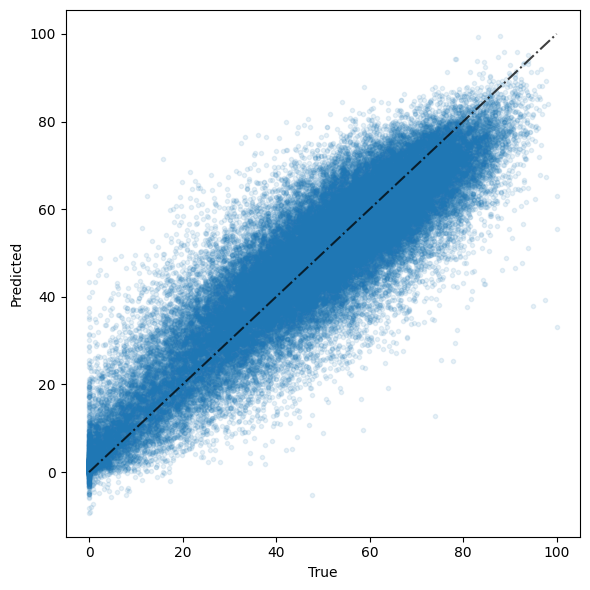

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_true, y_pred, alpha=0.1, marker=".")
ax.plot((y_true.min(), y_true.max()), (y_true.min(), y_true.max()), "k-.", alpha=0.75)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.tight_layout()

In [10]:
wandb.log({"scatter": wandb.Image(fig)})

### Distribution Histograms

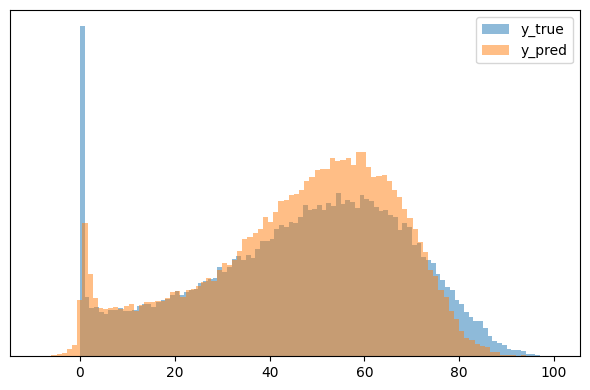

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(y_true.ravel(), bins=100, alpha=0.5, label="y_true")
ax.hist(y_pred.ravel(), bins=100, alpha=0.5, label="y_pred")
ax.legend()
ax.set_yticks([])
plt.tight_layout()

In [12]:
wandb.log({"hist": wandb.Image(fig)})

### Validation Predictions

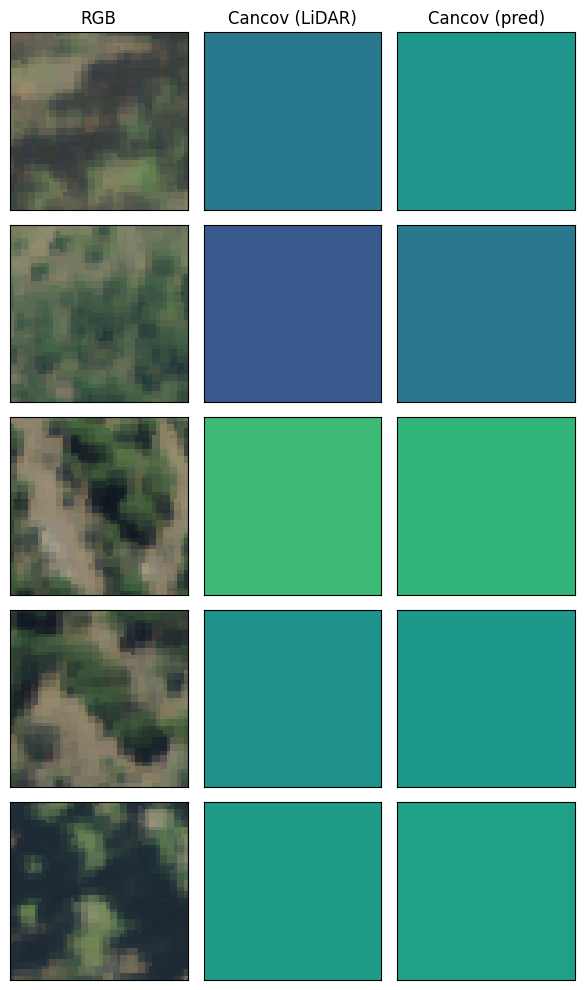

In [13]:
X_ref = np.concatenate([data[0] for data in val.as_numpy_iterator()])
rng = np.random.default_rng(99)
check_samples = rng.choice(range(len(X_ref)), size=5, replace=False)

fig, ax = plt.subplots(len(check_samples), 3, figsize=(6, 2 * len(check_samples)))

for i, sample in enumerate(check_samples):
    ax[i, 0].imshow(X_ref[sample, ..., :3])
    ax[i, 1].imshow(y_true[sample, ...], vmin=y_true.min(), vmax=y_true.max())
    ax[i, 2].imshow(y_pred[sample, ...], vmin=y_true.min(), vmax=y_true.max())

ax[0, 0].set_title("RGB")
ax[0, 1].set_title("Cancov (LiDAR)")
ax[0, 2].set_title("Cancov (pred)")

# Remove ticks
for sub_ax in ax.ravel():
    sub_ax.set_xticks([])
    sub_ax.set_yticks([])

plt.tight_layout()

In [14]:
wandb.log({"validation_chips": wandb.Image(fig)})

## Log Images

Run `python scripts/export_evaluation_naip.py` before running the cell below.

In [16]:
# for img_path in Path("../data/naip/").glob("*.tif"):
#     pred_img = predict_image(
#         img_path=img_path,
#         model=run.model,
#         in_tile_shape=(*wrapper.naip_shape, len(BANDS)),
#         out_tile_shape=wrapper.lidar_shape,
#         in_res=wrapper.naip_res,
#         out_res=wrapper.lidar_res,
#     )

#     vis_img = (
#         (((pred_img - y_true.min()) / y_true.max()) * 255)
#         .clip(0, 255)
#         .astype(np.uint8)
#         .values
#     )

#     fig, ax = plt.subplots(figsize=(6, 6))
#     ax.imshow(vis_img)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.tight_layout()

#     wandb.log({img_path.stem: wandb.Image(fig)})

## Tear Down

In [15]:
wandb.run.finish()

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▄▃▄▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▆▄▄▄▄▃▂▂▂▂▂▂▂▃▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▅▄▄▃▄▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,103
epoch/learning_rate,0.0001
epoch/loss,85.90899
